# Car Sales


In [62]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
%matplotlib inline

## Load Data

The data is sourced from the “Car Features and MSRP” dataset on Kaggle.com that was uploaded in 2016. The dataset contains a set of features and the MSRP (Manufacturers Suggested Retail Price) of each car. We will begin by loading the data into a polars dataframe, correcting some datatypes, and looking at the first few rows of the dataset.


In [63]:
df = pl.read_csv("data/raw/car_sales/data.csv")
print("raw shape: ", df.shape)
rename_map = {col: col.lower().replace(" ", "_") for col in df.columns}

df = df.rename(rename_map).with_row_count("id")
df = df.with_columns(
    [
        pl.col(col).str.replace_all(" ", "_").str.to_lowercase()
        for col in df.columns
        if df[col].dtype == pl.Utf8
    ]
).with_columns(
    pl.col(
        "make",
        "model",
        "engine_fuel_type",
        "transmission_type",
        "driven_wheels",
        "vehicle_size",
        "vehicle_style",
    ).cast(pl.Categorical),
)
total_rows = df.shape[0]
df.head()

raw shape:  (11914, 16)


id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
u32,cat,cat,i64,cat,i64,i64,cat,cat,i64,str,cat,cat,i64,i64,i64,i64
0,"""bmw""","""1_series_m""",2011,"""premium_unlead…",335,6,"""manual""","""rear_wheel_dri…",2,"""factory_tuner,…","""compact""","""coupe""",26,19,3916,46135
1,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""convertible""",28,19,3916,40650
2,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,high-pe…","""compact""","""coupe""",28,20,3916,36350
3,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""coupe""",28,18,3916,29450
4,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury""","""compact""","""convertible""",28,18,3916,34500


## Data Cleaning

### Nulls

One thing that can trip up an analysis is "missing" data. Data can be missing for a variety of reasons. I checked the data entries where there were null entries and found that:

- nulls in the "engine_fuel_type", "engine_hp", and "number_of_doors" columns were likely to actually be missing. These are facts that should be determinable for any kind of car or fuel type.
- nulls in the "engine_cylinders" column weren't missing per se, but rather were a way of indicating that the car had either an electric or rotary engine, neither of which have cylinders.

So, I dropped the rows with null values in the "engine_fuel_type", "engine_hp", and "number_of_doors" columns (total of 73 entries, or about 0.6% of the data), and replaced the null values in the "engine_cylinders" column with 0 as appropriate.


In [64]:
df.describe().filter(pl.col("describe") == "null_count")

describe,id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
str,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,str,f64,f64,f64,f64
"""null_count""",0.0,"""0""","""0""",0.0,"""3""",69.0,30.0,"""0""","""0""",6.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0


In [65]:
count_before = df.shape[0]
df = df.with_columns(
    pl.col("engine_cylinders").fill_null(0)  # rotary and electric engines
).drop_nulls(["engine_fuel_type", "engine_hp", "number_of_doors"])
count_after = df.shape[0]
print(
    f"dropped {count_before - count_after} rows ({(count_before - count_after)/count_before:.2%})"
)

dropped 73 rows (0.61%)


### Poorly Represented Categories

Some categories had very small representation in the dataset, for example the natural gas and electric fuel types. We will filter out categories with less than 1% representation in the dataset, as these categories are likely to be unrepresentative. This removes 104 data entries or about 0.9% of the data.


In [66]:
print_df = (
    df.group_by("engine_fuel_type")
    .agg(pl.count("id").alias("count"))
    .with_columns((pl.col("count") / total_rows))
    .sort("count", descending=True)
    .select(
        pl.col("engine_fuel_type"),
        (pl.col("count") * 100).round(1).alias("percent"),
    )
)
print_df

engine_fuel_type,percent
cat,f64
"""regular_unlead…",60.1
"""premium_unlead…",16.9
"""premium_unlead…",12.7
"""flex-fuel_(unl…",7.5
"""diesel""",1.3
"""flex-fuel_(pre…",0.5
"""flex-fuel_(pre…",0.2
"""electric""",0.2
"""natural_gas""",0.0


dropped 0 rows (0.00%)


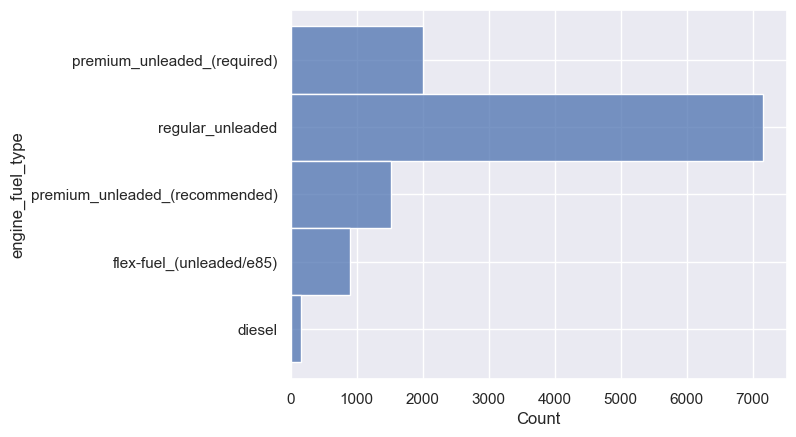

In [74]:
min_count = total_rows * 0.01

count_before = df.shape[0]
value_counts = df.group_by("engine_fuel_type").agg(pl.count("id").alias("count"))
df = (
    df.join(value_counts, on="engine_fuel_type")
    .filter(pl.col("count") >= min_count)
    .drop("count")
)
count_after = df.shape[0]
print(
    f"dropped {count_before - count_after} rows ({(count_before - count_after)/count_before:.2%})"
)

sns.histplot(df, y="engine_fuel_type")
_ = plt.plot()

### Membership of Multiple Categories

In the market_category column, some entries have membership of multiple categories, e.g. 'factory_tuner,luxury,high-performance'. This column can't just be converted to a category, as it will result in far more categories based on teh variety of combinations that are possible. So, we will one-hot-encode membership of each category below.


In [70]:
df_market = (
    (
        df.select("id", "market_category")
        .with_columns([pl.col("market_category").str.split(",")])
        .explode("market_category")
    )
    .pivot(
        index="id",
        values="id",
        columns="market_category",
        aggregate_function="count",
    )
    .fill_null(0)
)
rename_map = {
    col: "market_" + col.lower().replace(" ", "_") if col != "id" else col
    for col in df_market.columns
}
df_market = df_market.rename(rename_map)
df = df.join(df_market, on="id").drop("market_category")
df.head()

id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,market_factory_tuner,market_luxury,market_high-performance,market_performance,market_flex_fuel,market_n/a,market_hatchback,market_hybrid,market_diesel,market_exotic,market_crossover
u32,cat,cat,i64,cat,i64,i64,cat,cat,i64,cat,cat,i64,i64,i64,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,"""bmw""","""1_series_m""",2011,"""premium_unlead…",335,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""coupe""",26,19,3916,46135,1,1,1,0,0,0,0,0,0,0,0
1,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""convertible""",28,19,3916,40650,0,1,0,1,0,0,0,0,0,0,0
2,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""coupe""",28,20,3916,36350,0,1,1,0,0,0,0,0,0,0,0
3,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""coupe""",28,18,3916,29450,0,1,0,1,0,0,0,0,0,0,0
4,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""convertible""",28,18,3916,34500,0,1,0,0,0,0,0,0,0,0,0


### Target Distribution

The target variable, MSRP, is highly skewed. We will log transform it to make it more normally distributed.


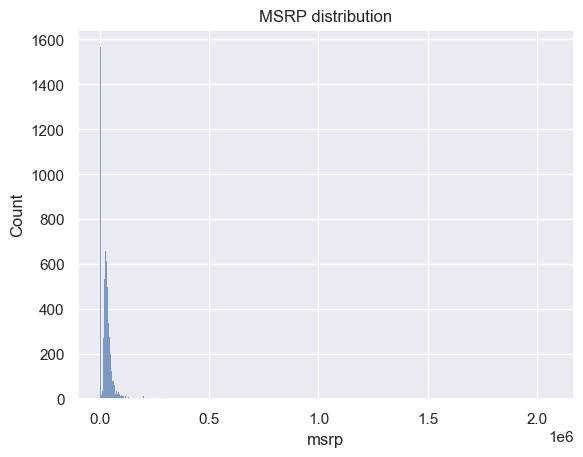

In [72]:
sns.histplot(df, x="msrp")
plt.title("MSRP distribution")
_ = plt.plot()

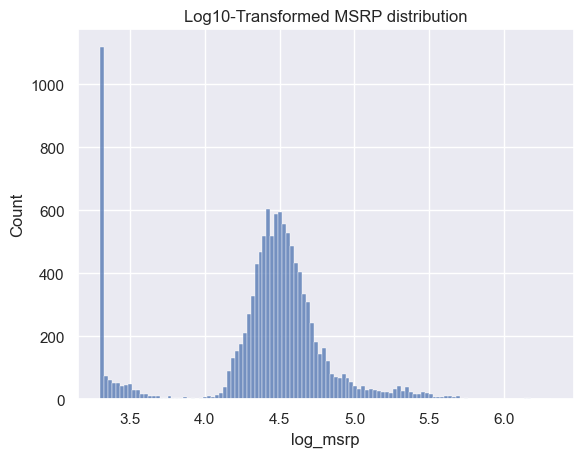

In [78]:
df = df.with_columns(
    pl.col("msrp").log10().alias("log_msrp"),
)
sns.histplot(df, x="log_msrp")
plt.title("Log10-Transformed MSRP distribution")
_ = plt.plot()

## References

“Car Features and MSRP” (2016), Kaggle.com, available at https://www.kaggle.com/datasets/CooperUnion/cardataset (accessed November 29, 2023).
